# Train decoder

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

Load the dataset with hugging face and split between train and test.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_image_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [3]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [4]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [5]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [6]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image'])


### Create PyTorch dataloader

In [7]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 450, 450])
original_image torch.Size([1, 450, 450, 3])


/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

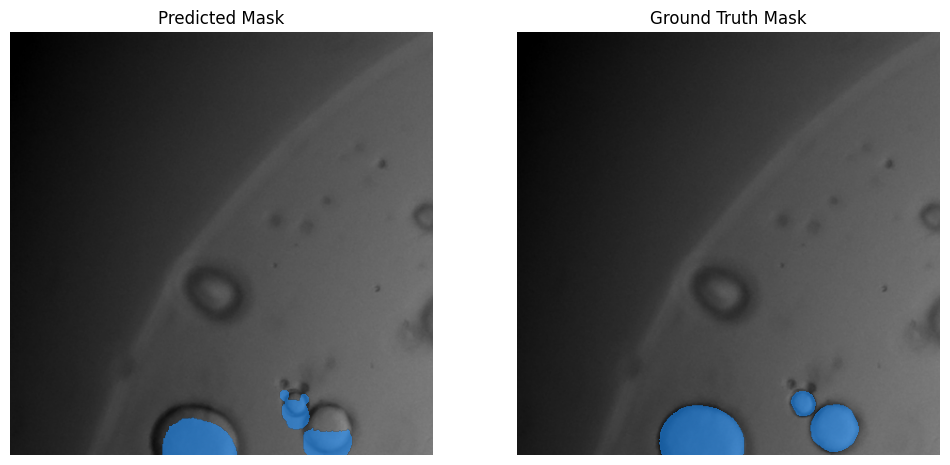

In [10]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
first_masks = []
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    first_masks.append(first_mask_seg)
    show_mask(first_mask_seg, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
axes[1].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    show_mask(ground_truth_masks, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [11]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Define loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 200
train_model(model = model, optimizer = optimizer, seg_loss = geom_loss, 
            dataloader = test_dataloader, num_epochs = num_epochs, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


EPOCH: 1
Mean loss: 0.5895277112722397


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


EPOCH: 2
Mean loss: 0.6389774878819784


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 3
Mean loss: 0.5043581823507944


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 4
Mean loss: 0.4510374665260315


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


EPOCH: 5
Mean loss: 0.5212800204753876


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 6
Mean loss: 0.296603520711263


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


EPOCH: 7
Mean loss: 0.4745047638813655


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


EPOCH: 8
Mean loss: 0.4681077500184377


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


EPOCH: 9
Mean loss: 0.2942192852497101


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


EPOCH: 10
Mean loss: 0.3740213066339493


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


EPOCH: 11
Mean loss: 0.5142183601856232


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


EPOCH: 12
Mean loss: 0.2730383475621541


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


EPOCH: 13
Mean loss: 0.25901979207992554


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 14
Mean loss: 0.2804158677657445


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


EPOCH: 15
Mean loss: 0.30510587990283966


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


EPOCH: 16
Mean loss: 0.2740514775117238


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 17
Mean loss: 0.47953400015830994


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


EPOCH: 18
Mean loss: 0.2522459278504054


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 19
Mean loss: 0.2682775780558586


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 20
Mean loss: 0.33492209513982135


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 21
Mean loss: 0.2716791207591693


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 22
Mean loss: 0.2837502360343933


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


EPOCH: 23
Mean loss: 0.24113051096598306


100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


EPOCH: 24
Mean loss: 0.3375215331713359


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 25
Mean loss: 0.34835148106018704


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 26
Mean loss: 0.2622160017490387


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 27
Mean loss: 0.22746479759613672


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 28
Mean loss: 0.42296505471070606


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 29
Mean loss: 0.2535119528571765


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 30
Mean loss: 0.2645665854215622


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 31
Mean loss: 0.2687959223985672


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 32
Mean loss: 0.2373968263467153


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 33
Mean loss: 0.25305015097061795


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 34
Mean loss: 0.282203808426857


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 35
Mean loss: 0.22138696908950806


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 36
Mean loss: 0.1862252652645111


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 37
Mean loss: 0.32085616886615753


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 38
Mean loss: 0.20248641073703766


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 39
Mean loss: 0.18868400156497955


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 40
Mean loss: 0.22725916902224222


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


EPOCH: 41
Mean loss: 0.23926460867126784


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 42
Mean loss: 0.200474480787913


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 43
Mean loss: 0.19178887705008188


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 44
Mean loss: 0.2139242080350717


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 45
Mean loss: 0.19378478328386942


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 46
Mean loss: 0.26972558349370956


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 47
Mean loss: 0.21442169323563576


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


EPOCH: 48
Mean loss: 0.18543581664562225


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


EPOCH: 49
Mean loss: 0.2003386045495669


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 50
Mean loss: 0.17962189515431723


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 51
Mean loss: 0.21900894741217294


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 52
Mean loss: 0.21148475632071495


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 53
Mean loss: 0.18917322407166162


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 54
Mean loss: 0.1884008546670278


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 55
Mean loss: 0.2613379582762718


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


EPOCH: 56
Mean loss: 0.19332045565048853


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 57
Mean loss: 0.20272237931688628


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 58
Mean loss: 0.17910455043117204


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 59
Mean loss: 0.23206166550517082


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 60
Mean loss: 0.17602460210522017


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 61
Mean loss: 0.17857103794813156


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 62
Mean loss: 0.17402309800187746


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 63
Mean loss: 0.17009946952263513


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 64
Mean loss: 0.1743894082804521


100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


EPOCH: 65
Mean loss: 0.16499286890029907


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 66
Mean loss: 0.17002647245923677


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 67
Mean loss: 0.13135324915250143


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 68
Mean loss: 0.15794443587462106


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


EPOCH: 69
Mean loss: 0.15282303343216577


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 70
Mean loss: 0.16054330145319304


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 71
Mean loss: 0.15282980725169182


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 72
Mean loss: 0.2183109944065412


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 73
Mean loss: 0.13214081774155298


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 74
Mean loss: 0.14092291394869486


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 75
Mean loss: 0.1409254396955172


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 76
Mean loss: 0.15306595961252847


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 77
Mean loss: 0.13698212429881096


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 78
Mean loss: 0.1484968215227127


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 79
Mean loss: 0.16611244715750217


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 80
Mean loss: 0.13579050078988075


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 81
Mean loss: 0.12773947790265083


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 82
Mean loss: 0.1436905600130558


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 83
Mean loss: 0.13293182104825974


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 84
Mean loss: 0.12330157806475957


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 85
Mean loss: 0.12866318970918655


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


EPOCH: 86
Mean loss: 0.16391942898432413


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


EPOCH: 87
Mean loss: 0.12799636522928873


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 88
Mean loss: 0.185243658721447


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 89
Mean loss: 0.1360644226272901


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 90
Mean loss: 0.11605279644330342


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 91
Mean loss: 0.11605799322326978


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 92
Mean loss: 0.11427718897660573


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 93
Mean loss: 0.12408721819519997


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 94
Mean loss: 0.11337511986494064


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 95
Mean loss: 0.11280578933656216


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 96
Mean loss: 0.11397452900807063


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 97
Mean loss: 0.10939796517292659


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 98
Mean loss: 0.10950269053379695


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 99
Mean loss: 0.13017868561049303


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 100
Mean loss: 0.12121699626247089


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 101
Mean loss: 0.10037090877691905


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 102
Mean loss: 0.09326464124023914


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 103
Mean loss: 0.10626825504004955


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 104
Mean loss: 0.10369547332326572


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 105
Mean loss: 0.09592979152997334


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 106
Mean loss: 0.10424386834104855


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 107
Mean loss: 0.09128708516558011


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 108
Mean loss: 0.08206867054104805


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 109
Mean loss: 0.09429420841236909


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 110
Mean loss: 0.07180872311194737


100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


EPOCH: 111
Mean loss: 0.12428050860762596


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 112
Mean loss: 0.09646311402320862


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 113
Mean loss: 0.08834094740450382


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 114
Mean loss: 0.08191282364229362


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 115
Mean loss: 0.08694732002913952


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 116
Mean loss: 0.0716114876170953


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 117
Mean loss: 0.08460922539234161


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 118
Mean loss: 0.07289863377809525


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 119
Mean loss: 0.07373037313421567


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 120
Mean loss: 0.11655495129525661


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 121
Mean loss: 0.0734705434491237


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 122
Mean loss: 0.08594503874580066


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 123
Mean loss: 0.07309503232439359


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 124
Mean loss: 0.08060638358195622


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 125
Mean loss: 0.0788169763982296


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 126
Mean loss: 0.07379616672794025


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 127
Mean loss: 0.0632647667080164


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 128
Mean loss: 0.07250912984212239


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


EPOCH: 129
Mean loss: 0.06393264482418697


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 130
Mean loss: 0.0611162589242061


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 131
Mean loss: 0.057746910800536476


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 132
Mean loss: 0.059624429792165756


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 133
Mean loss: 0.05917170581718286


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 134
Mean loss: 0.12739873677492142


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 135
Mean loss: 0.05990378248194853


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 136
Mean loss: 0.058260359490911164


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 137
Mean loss: 0.07686546196540196


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


EPOCH: 138
Mean loss: 0.1165122278034687


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 139
Mean loss: 0.06958492038150628


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 140
Mean loss: 0.06561573346455891


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 141
Mean loss: 0.055387030666073166


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 142
Mean loss: 0.061165543273091316


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 143
Mean loss: 0.06194258791704973


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 144
Mean loss: 0.05233319103717804


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 145
Mean loss: 0.0577223344395558


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 146
Mean loss: 0.056857806319991745


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 147
Mean loss: 0.05313673987984657


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 148
Mean loss: 0.06574097896615665


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 149
Mean loss: 0.05412081132332484


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 150
Mean loss: 0.049766737346847854


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 151
Mean loss: 0.049014683502415814


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 152
Mean loss: 0.04825751110911369


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 153
Mean loss: 0.04694929967323939


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 154
Mean loss: 0.04751609514156977


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 155
Mean loss: 0.04041697271168232


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 156
Mean loss: 0.07180445579191048


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 157
Mean loss: 0.05177884300549825


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 158
Mean loss: 0.05270275970300039


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 159
Mean loss: 0.05167878605425358


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 160
Mean loss: 0.04903148487210274


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 161
Mean loss: 0.04764177774389585


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 162
Mean loss: 0.03887283243238926


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 163
Mean loss: 0.048485116412242256


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 164
Mean loss: 0.04478101494411627


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 165
Mean loss: 0.04133576713502407


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 166
Mean loss: 0.042745281010866165


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 167
Mean loss: 0.039474532629052796


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 168
Mean loss: 0.042623287066817284


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 169
Mean loss: 0.04277680069208145


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 170
Mean loss: 0.03777832599977652


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 171
Mean loss: 0.043618662282824516


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 172
Mean loss: 0.03881393621365229


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 173
Mean loss: 0.04648667201399803


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 174
Mean loss: 0.07558906823396683


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 175
Mean loss: 0.04459185587863127


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 176
Mean loss: 0.04591761901974678


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 177
Mean loss: 0.03652036562561989


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 178
Mean loss: 0.03712583084901174


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


EPOCH: 179
Mean loss: 0.03489814636607965


100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


EPOCH: 180
Mean loss: 0.044355745116869606


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 181
Mean loss: 0.04491476776699225


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 182
Mean loss: 0.0409286388506492


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 183
Mean loss: 0.040561301012833915


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 184
Mean loss: 0.038441579788923264


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 185
Mean loss: 0.04947161115705967


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 186
Mean loss: 0.034452363227804504


100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


EPOCH: 187
Mean loss: 0.036508528205255665


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 188
Mean loss: 0.037628188729286194


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 189
Mean loss: 0.04593734381099542


100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


EPOCH: 190
Mean loss: 0.03784277414282163


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 191
Mean loss: 0.032831959736843906


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 192
Mean loss: 0.03586786643912395


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 193
Mean loss: 0.0379792811969916


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 194
Mean loss: 0.03941884015997251


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 195
Mean loss: 0.038276948034763336


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 196
Mean loss: 0.03392529673874378


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 197
Mean loss: 0.037139776473244034


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


EPOCH: 198
Mean loss: 0.0334603413939476


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


EPOCH: 199
Mean loss: 0.032401470777889095


100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

EPOCH: 200
Mean loss: 0.032087018402914204


See now the results.

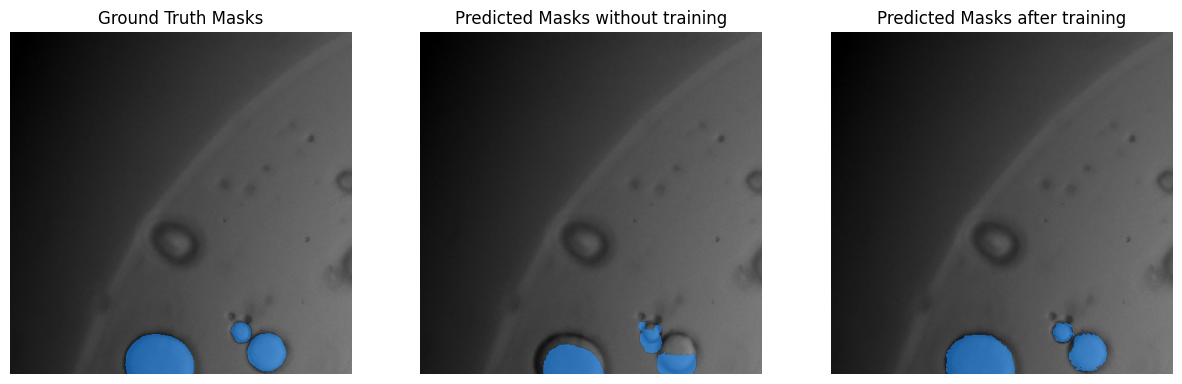

In [12]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    show_mask(ground_truth_masks, axes[0])
axes[0].set_title("Ground Truth Masks")
axes[0].axis("off")

# Plot Predicted Mask before training
axes[1].imshow(np.array(batch["original_image"]).squeeze())
for mask in first_masks:
    show_mask(mask, axes[1])
axes[1].set_title("Predicted Masks without training")
axes[1].axis("off")

# Plot Predicted Mask after training
axes[2].imshow(np.array(batch["original_image"]).squeeze())
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    show_mask(first_mask_seg, axes[2])
axes[2].set_title("Predicted Masks after training")
axes[2].axis("off")

plt.show()